In [1]:
from feos.dft import ExternalPotential, HelmholtzEnergyFunctional, Adsorption1D, Geometry, Pore1D, State
from feos.pcsaft import PcSaftParameters
from feos.si import ANGSTROM, KELVIN, BAR, NAV, KILO, METER, MOL, SIArray1

import pandas as pd
import numpy as np
import os
import json
from scipy.spatial import Voronoi, distance
from itertools import permutations

In [2]:
class SolidStructure:

    N_atom = 0
    dimensions = {
        "Lx": 0.0,
        "Ly": 0.0,
        "Lz": 0.0
    }
    forcefield = ''
    total_mass = 0.0

    def __init__(self,structure):
 
        self.name = structure

        database = os.path.join(os.getcwd(),'structure_parameters','solid_database.json')
    
        with open(database) as f:
            data = json.load(f)

            for i in range(len(data)):
                if data[i]['Name']==self.name:
                    self.N_atom = data[i]['N_atom']
                    self.dimensions = data[i]['Dimensions']
                    self.forcefield = data[i]['Forcefield']
                    
                    
    def read_structure(self):
        struct_param = os.path.join(os.getcwd(),'structure_parameters')
        structure_df = pd.read_csv(os.path.join(struct_param,'{}.dat'.format(self.name)),names=['x','y','z','Type'], delim_whitespace=True)
        
        filename = os.path.join(struct_param,'{}.dat'.format(self.forcefield))
        forcefield_df = pd.read_csv(filename,names=['Type','sigma','epsilon','mass'], delim_whitespace=True)

        coordinates = np.array([structure_df["x"], structure_df["y"], structure_df["z"]])
        
        sigma_ss = np.zeros(len(structure_df["x"]))
        epsilon_k_ss = np.zeros_like(sigma_ss)
        
        for i in range(len(sigma_ss)):
            sigma_ss[i] = forcefield_df.sigma[forcefield_df.Type==structure_df["Type"][i]]
            epsilon_k_ss[i] = forcefield_df.epsilon[forcefield_df.Type==structure_df["Type"][i]]
        
        self.total_mass = np.sum(np.array([forcefield_df.mass[forcefield_df.Type==t]for t in structure_df.Type])) * 1.66054e-27

        return coordinates, sigma_ss, epsilon_k_ss   

In [3]:
structure = SolidStructure('LTA')
coordinates, sigma_ss, epsilon_ss = structure.read_structure()
system_size = [structure.dimensions["Lx"] * ANGSTROM, structure.dimensions["Lx"] * ANGSTROM, structure.dimensions["Lx"] * ANGSTROM]

In [4]:
%%time
vor = Voronoi(coordinates.T)

minimum_distance = 0.0
dist = np.zeros(int(vor.vertices.size / 2))
for i,point in enumerate(vor.vertices):
    if(point[0] >= 0.0 and point[0] <= structure.dimensions["Lx"] and point[1] >= 0.0 and point[1] <= structure.dimensions["Ly"]):
        dist[i] = np.min(distance.cdist(np.array([point]),coordinates.T))
pore_radius = np.max(dist)
print(pore_radius,np.argmax(dist))
pore_center = [vor.vertices[np.argmax(dist)][0], vor.vertices[np.argmax(dist)][1], vor.vertices[np.argmax(dist)][2]]
print(pore_center)

6.84534814234455 3220
[5.9595, 5.9594999999999985, 5.9595]
CPU times: user 351 ms, sys: 3.92 ms, total: 354 ms
Wall time: 359 ms


In [5]:
params = PcSaftParameters.from_json(['argon'],'structure_parameters/noble_gases.json')
func = HelmholtzEnergyFunctional.pcsaft(params)

In [6]:
potential = ExternalPotential.FreeEnergyAveraged(coordinates * ANGSTROM, sigma_ss, epsilon_ss, pore_center, system_size, [51, 51])
pore = Pore1D(Geometry.Spherical, 5.9595 * ANGSTROM, potential, 128)

In [7]:
isotherm = Adsorption1D.adsorption_isotherm(func, 298.0 * KELVIN, SIArray1.linspace(1.0e-3 * BAR, 5.0 * BAR, 51), pore)

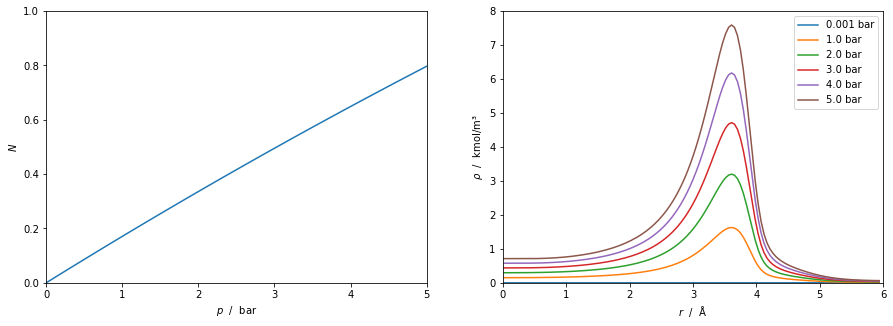

In [8]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(isotherm.pressure/BAR, isotherm.total_adsorption*NAV)
ax[0].set_xlabel('$p~~/~~\\mathrm{bar}$')
ax[0].set_ylabel('$N$')
ax[0].set_xlim(0,5)
ax[0].set_ylim(0,1)

for profile in isotherm.profiles[::10]:
    ax[1].plot(profile.r/ANGSTROM, (profile.density/(KILO*MOL/METER**3)).T, label=f'{profile.bulk.pressure()/BAR:.2} bar')
ax[1].set_xlabel('$r~~/~~\\mathrm{\AA}$')
ax[1].set_ylabel('$\\rho~~/~~\\mathrm{kmol/m³}$')
ax[1].set_xlim(0,6)
ax[1].set_ylim(0,8)
ax[1].legend()